# Programmatic access and analysis of the MICrONS dataset

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> Electron Microscopy (EM) data enables morphological reconstruction of neurons and detection of their synaptic connectivity </b>. The <a href=https://www.microns-explorer.org/cortical-mm3>MICrONS dataset </a> is one of the largest datasets currently available spanning all layers of visual cortex. We will be using this dataset to query the connectivity between the excitatory neurons in the visual cortex. The exercises will cover the connectivity with inhibitory neurons. 

    
<em> Note on the data: </em> To make our lifes easier, we already queried the necessary data from the database and made it available as files that can be readily read with pandas. The entire dataset is hosted using the <a href=https://caveconnectome.github.io/sections/cave_overview.html> Connectome Annotation Versioning Engine (CAVE) </a>. A separate notebook shows how to use CAVE and how the files used in this notebook were created. 
    
    
</div>

In [1]:
# Paths to cell dataa

syn_data_url = "https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/synapses_proofread_V1_neurons_1293.feather"
cell_data_url = "https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/cell_info_1293.feather" 

In [2]:
!pip install skeleton_plot
!pip install caveclient 

In [78]:
import caveclient
import skeleton_plot as skelplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> CAVEclient

Copy description for how to get token and copy in here from the NeuroAI workshop

Replace datastack with public one after creating LTS
    
</div>

In [4]:
my_token = None

In [5]:
client = caveclient.CAVEclient("minnie65_phase3_v1", auth_token=my_token)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Cell information

### Cell types

<b> Summarize cell typing - manual and automated </b>

### Proofreading information


Proofreading is necessary to obtain accurate reconstructions of a cell. In the MICrONS dataset, the general rule is that dendrites onto cells with a cell body are sufficiently proofread to trust synaptic connections onto a cell. Axons on the other hand require so much proofreading that only ~1,650 cells have proofread axons ... <b> extend </b>
    
    
</div>

In [6]:
cell_df = pd.read_feather(cell_data_url)

In [7]:
cell_df["proofreading_strategy"].value_counts()

proofreading_strategy
                           89772
axon_partially_extended     1398
axon_interareal              130
axon_fully_extended          124
Name: count, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Synapse information

This table has all synapses for the proofread cells in V1
    
    
</div>

In [73]:
syn_df = pd.read_feather(syn_data_url)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Neuron morphology: plotting skeletons
    
</div>

In [118]:
skel_color_map = {3: "firebrick", 4: "salmon", 2: "steelblue", 1: "olive"}

def plot_skeleton(sk_d: dict, plot_soma=True, ax=None):
    """Plots a skeleton.
    
    Args:
        sk: skeleton dict as returned from CAVEclient
        
    Returns: 
        ax: plot axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 10), dpi=150)
    
    skelplot.plot_tools.plot_verts(np.array(sk_d["vertices"]), np.array(sk_d["edges"]), radius=np.array(sk_d["radius"]) / 1000 * 1,
                                   ax=ax, skel_colors = sk_d["compartment"], title = "", skel_alpha = 1., 
                                   line_width = 5, x = 'x', y = 'y',  plot_soma = plot_soma, soma_node = sk_d["root"],
                                   color = 'darkslategray', soma_size = 120, invert_y = True, 
                                   skel_color_map = skel_color_map, x_min_max = None, 
                                   y_min_max = None, capstyle = "round", joinstyle = "round",)

    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['bottom'].set_visible(False)
    ax.axis('off')
    
    return ax

In [96]:
root_id = cell_df[cell_df["proofreading_strategy"] == "axon_fully_extended"].iloc[3]["pt_root_id"]
sk_d = client.skeleton.get_skeleton(root_id, output_format="dict")

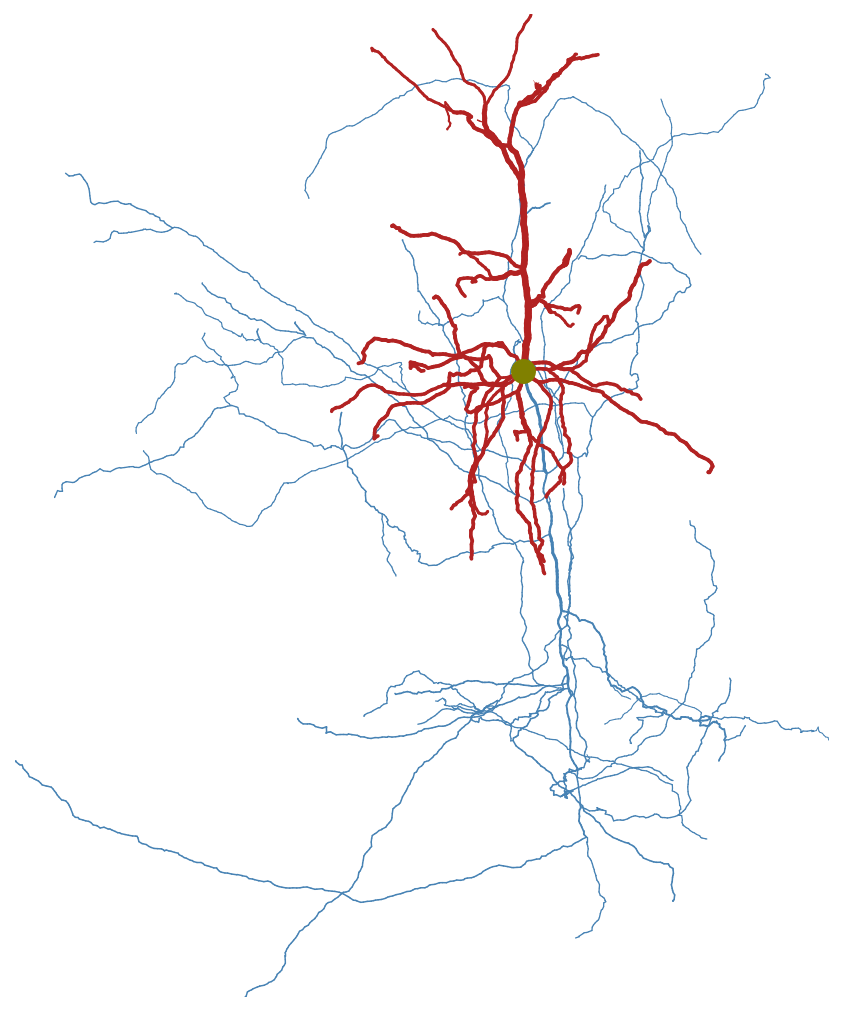

In [97]:
ax = plot_skeleton(sk_d)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Neuron morphology & synapses
    
</div>

In [98]:
def filter_synapse_table(synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None):   
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """
    
    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        pre_m = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_m = np.ones(len(synapse_table), dtype=bool)
        
    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        post_m = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_m = np.ones(len(synapse_table), dtype=bool)
        
    return synapse_table[pre_m & post_m]

In [99]:
pre_syns = filter_synapse_table(syn_df, pre_root_ids=[root_id])

In [135]:
pre_syns.head(5)

,id,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,pre_pt_root_id,post_pt_root_id,size
1424,167994184,721456,733616,830000,864691135988769027,864691131921105585,736
3272,110242280,599840,439624,978200,864691135988769027,864691132117678230,5724
3326,165911119,722176,443760,864960,864691135988769027,864691132122911308,1628
4668,156639854,712304,392392,978760,864691135988769027,864691132234089570,3456
5193,58463756,481072,478928,852480,864691135988769027,864691132271207236,2296


<Axes: xlabel='ctr_pt_position_x', ylabel='ctr_pt_position_y'>

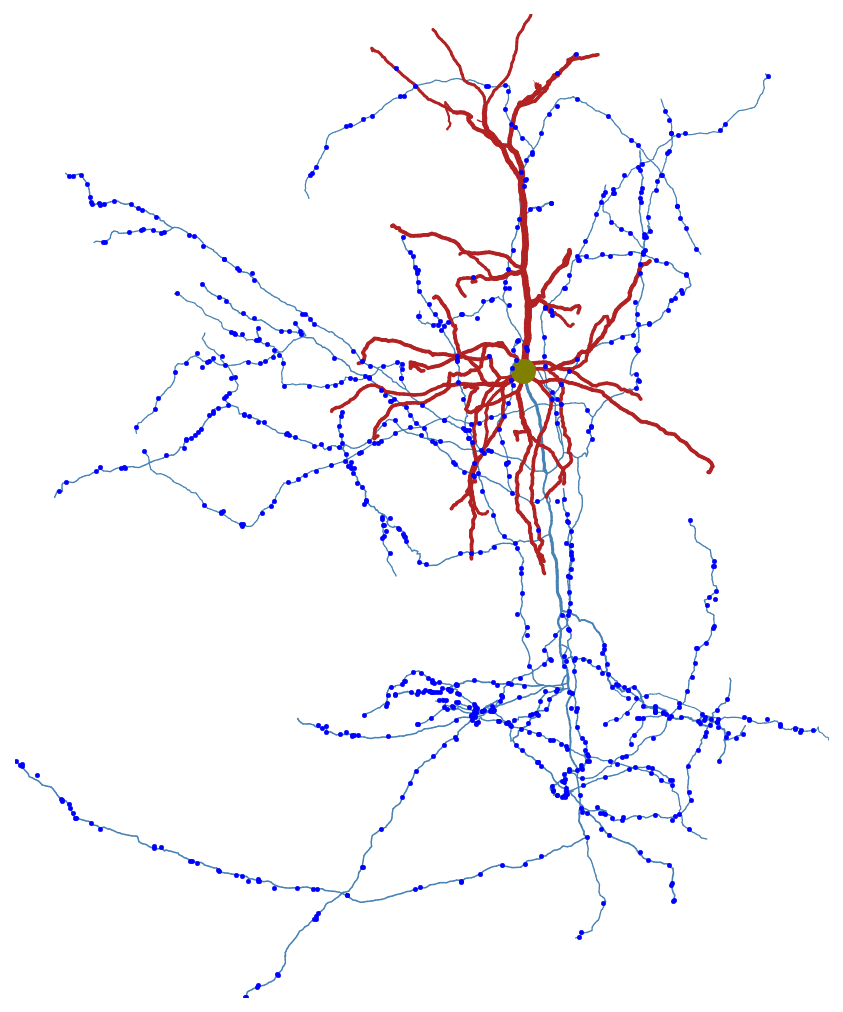

In [111]:
ax = plot_skeleton(sk_d)

sns.scatterplot(data=pre_syns, x="ctr_pt_position_x", y="ctr_pt_position_y", 
                s=5, color="b", ax=ax, edgecolor=None, zorder=100) 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1:</b> Use the filter function above to create a dataframe of all postsynaptic synapses and create a version of the plot above that includes these postsynaptic synapses. 
    
</div>

In [101]:
post_syns = filter_synapse_table(syn_df, post_root_ids=[root_id])

<Axes: xlabel='ctr_pt_position_x', ylabel='ctr_pt_position_y'>

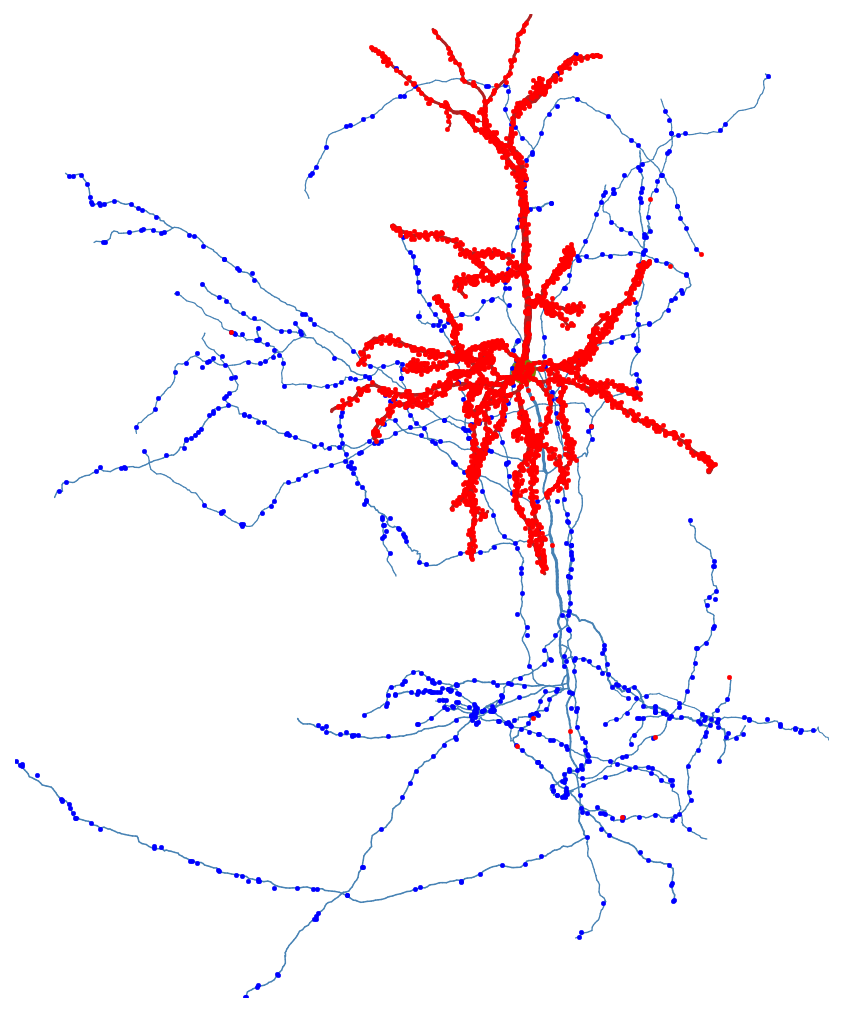

In [112]:
ax = plot_skeleton(sk_d)

sns.scatterplot(data=pre_syns, x="ctr_pt_position_x", y="ctr_pt_position_y", 
                s=5, color="b", ax=ax, edgecolor=None, zorder=100) 

sns.scatterplot(data=post_syns, x="ctr_pt_position_x", y="ctr_pt_position_y", 
                s=5, color="r", ax=ax, edgecolor=None, zorder=100) 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Synapse matrix

The synapses of neurons create a network of synaptic connections. One way of visualizing this connectivity is in a matrix form. Pandas provides the `pivot_table` function that we can use to make a matrix out of the tabular synapse data. For now, we will limit ourselves to the synapses between the proofread neurons.
    
Each synapses has a `size` value assigned to it. How to aggregate the sizes from multiple synapes between two neurons depends on the research question. Synapse sizes vary by a lot and are related to the physiological strength of a synapse. In this notebook, we ignore the synapse size and only look at binary (connected yes/no) connectivity.

</d>

In [114]:
proof_root_ids = np.array(cell_df[cell_df["proofreading_strategy"] != ""]["pt_root_id"])
proof_proof_syn_table = filter_synapse_table(syn_df, pre_root_ids=proof_root_ids, post_root_ids=proof_root_ids)

syn_mat = proof_proof_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                            values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)

# Make matrix is quadratic
syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

<Axes: xlabel='post_pt_root_id', ylabel='pre_pt_root_id'>

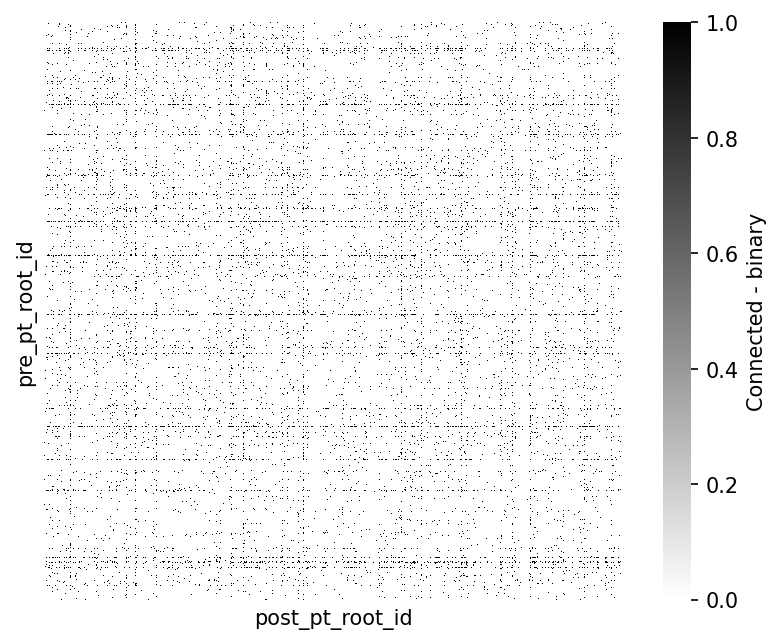

In [116]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
sns.heatmap(syn_mat, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Cell type information

<b>TODO: Add explainer and improve plot with cell types.</b>
    
</d>

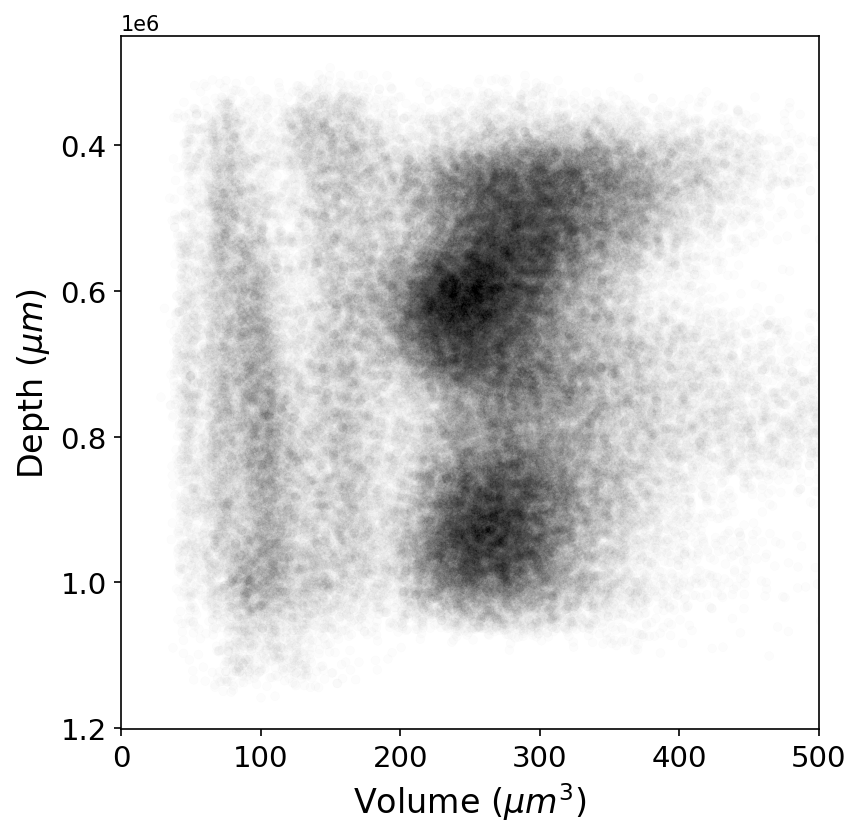

In [124]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=cell_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.01, color="k", ax=ax, legend=False)
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

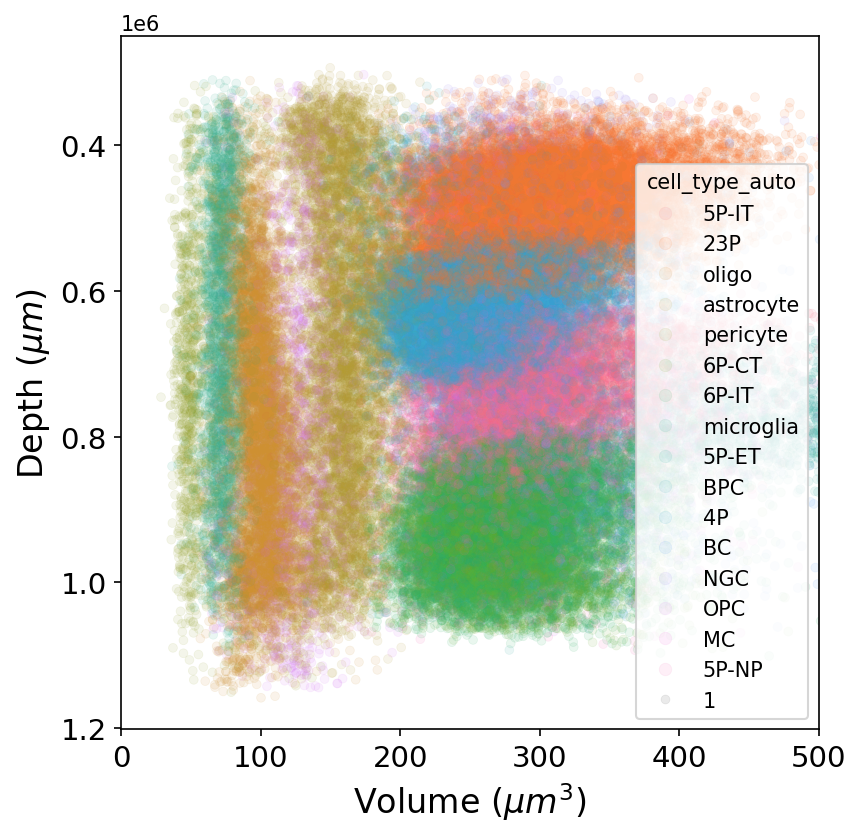

In [126]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=cell_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.1, color="k", ax=ax, 
                legend=True, hue="cell_type_auto")
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Sorting the synapse matrix with cell types
    
Let's combine the synaptic connecitivity with the cell type information. Below we provide logic for sorting a connectivity matrix using a list of labels.    
    
</d>

In [127]:
def sort_matrix_by_types(mat: pd.DataFrame, 
                         labels: pd.DataFrame, 
                         label_type_col: str = "cell_type_auto", 
                         label_id_col: str = "pt_root_id", 
                         post_labels: pd.DataFrame = None, 
                         post_label_type_col: str = None, 
                         post_label_id_col: str = None):
    """Sorts (synapse) matrix by labels.

    This function assumes a square synapse matrix!

    Args:
        mat: synapse matrix as pandas DataFrame
        labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        label_type_col: column name in labels for cell types
        label_id_col: column name in labels for root ids
        post_labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        post_label_type_col: column name in labels for cell types
        post_label_id_col: column name in labels for root ids

    Returns:
        mat_sorted: sorted matrix
        mat_labels: sorted labels; has the same length as matrix
    """
    
    if post_labels is None:
        post_labels = labels
    if post_label_type_col is None:
        post_label_type_col = label_type_col
    if post_label_id_col is None:
        post_label_id_col = label_id_col
        
    mat_sorted = mat.copy()
    
    pre_mat_labels = np.array(labels.set_index(label_id_col).loc[mat_sorted.index][label_type_col])
    pre_sorting = np.argsort(pre_mat_labels)

    post_mat_labels = np.array(post_labels.set_index(post_label_id_col).loc[mat_sorted.T.index][post_label_type_col])
    post_sorting = np.argsort(post_mat_labels)

    mat_sorted = mat_sorted.iloc[pre_sorting].T.iloc[post_sorting].T

    return mat_sorted, pre_mat_labels[pre_sorting], post_mat_labels[post_sorting]

In [133]:
proof_E_root_ids = np.array(cell_df[np.array(cell_df["proofreading_strategy"] != "") & np.array(cell_df["coarse_cell_type_auto"] == "E")]["pt_root_id"])
proof_proof_syn_table = filter_synapse_table(syn_df, pre_root_ids=proof_E_root_ids, post_root_ids=proof_E_root_ids)

syn_mat = proof_proof_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                            values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)

syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

syn_mat_ct, syn_mat_cell_types, _ = sort_matrix_by_types(syn_mat, cell_df, label_type_col="cell_type_auto")

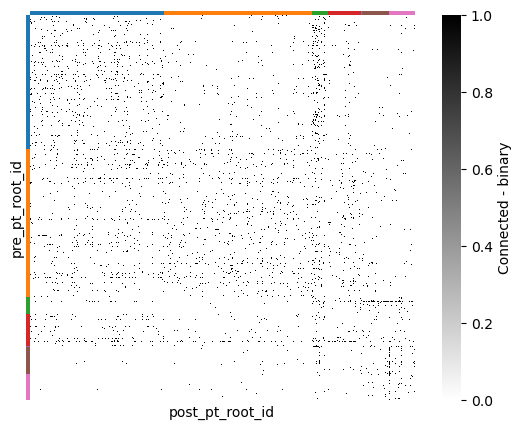

In [134]:
cts, ct_idx = np.unique(syn_mat_cell_types, return_inverse=True)
ct_colors = plt.get_cmap("tab10")(ct_idx)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(syn_mat_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})


# Adding row and column colors for cell types
for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.01, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))  